In [1]:
!pip install gensim

In [2]:
# Add environment Packages paths to conda
import os, sys
# env_name = "food_review"
# sys.path.append(f"C:\\Environments\\{env_name}\\lib\\site-packages\\")

import pandas as pd
import numpy as np
import warnings
# Text preprocessing packages
import nltk # Text libarary
# nltk.download('stopwords')
import string # Removing special characters {#, @, ...}
import re # Regex Package
from nltk.corpus import stopwords # Stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer # Stemmer & Lemmatizer
from gensim.utils import simple_preprocess  # Text ==> List of Tokens

# Text Embedding
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Saving Model
import pickle

# Visualization Packages
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)
%matplotlib inline

C:\Users\Mohamed\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
warnings.filterwarnings('ignore')

In [4]:
%%time
df = pd.read_csv(r"C:\Users\Mohamed\Downloads\archive (1)\Reviews.csv")

Wall time: 3.2 s


In [5]:
f"{df.shape[0]:,} Review"

'568,454 Review'

In [6]:
cols = ['Text', 'Score']
df_text = df[cols].copy()
df_text.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [7]:
df_text.drop_duplicates(inplace=True)

In [8]:
df_text['target'] = np.where(df_text['Score']>=3, 1, 0)
df_text

,Text,Score,target
0,I have bought several of the Vitality canned d...,5,1
1,Product arrived labeled as Jumbo Salted Peanut...,1,0
2,This is a confection that has been around a fe...,4,1
3,If you are looking for the secret ingredient i...,2,0
4,Great taffy at a great price. There was a wid...,5,1
...,...,...,...
568449,Great for sesame chicken..this is a good if no...,5,1
568450,I'm disappointed with the flavor. The chocolat...,2,0
568451,"These stars are small, so you can give 10-15 o...",5,1
568452,These are the BEST treats for training and rew...,5,1


<AxesSubplot:xlabel='target', ylabel='count'>

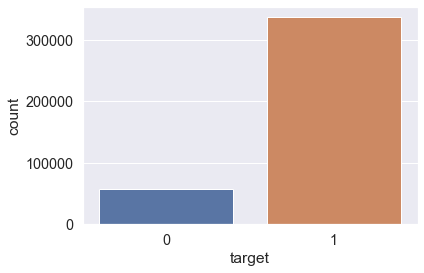

In [9]:
sns.countplot(df_text['target'])

In [10]:
NEG_N = df_text.target.value_counts()[0]
NEG_N

57084

In [11]:
df_pos = df_text[df_text['target'] == 1]['Text'].sample(NEG_N, replace=False)
df_pos.shape

(57084,)

In [12]:
df_text_balanced = pd.concat([df_text.loc[df_pos.index], df_text[df_text.target == 0]])
df_text_balanced

,Text,Score,target
406630,I'm a 20-year-old college student who religiou...,5,1
314445,Dietary needs are met with the unsalted peanut...,5,1
208286,"These are pretty decent, but are basically app...",4,1
456421,Keeps the cups off the counter!! It is a very ...,5,1
337902,"You taste, smell, and see real blueberries, an...",5,1
...,...,...,...
568433,I just bought this soup today at my local groc...,1,0
568434,This soup is mostly broth. Although it has a k...,2,0
568435,"It is mostly broth, with the advertised 3/4 cu...",2,0
568446,I had ordered some of these a few months back ...,2,0


<AxesSubplot:xlabel='target', ylabel='count'>

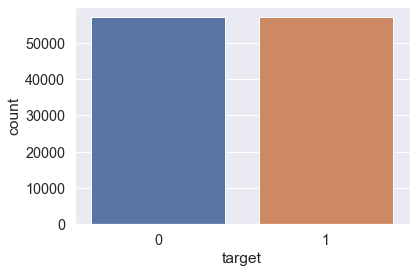

In [13]:
sns.countplot(df_text_balanced['target'])

In [14]:
df_text_balanced.drop(columns=['Score'],inplace=True)

In [15]:
stop_words = set(stopwords.words('english'))-{'not','against','aren\'t',"couldn't",'couldn','didn',"didn't","doesn't",'doesn',"don't",'don',"hadn't",'hasn',"hasn't",'haven',"haven't",'mustn',"mustn't",'need',"needn't",'no','should',"should've",'shouldn',"shouldn't",'wasn',"wasn't", 'weren',"weren't",'won',"won't",'wouldn',"wouldn't"}
stemmer = SnowballStemmer("english")
lemmatizer= WordNetLemmatizer()

In [16]:
df_text_balanced['no_stop_words'] = df_text_balanced['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [17]:
df_text_balanced

,Text,target,no_stop_words
406630,I'm a 20-year-old college student who religiou...,1,I'm 20-year-old college student religiously ea...
314445,Dietary needs are met with the unsalted peanut...,1,Dietary needs met unsalted peanuts. The local ...
208286,"These are pretty decent, but are basically app...",1,"These pretty decent, basically apple sauce des..."
456421,Keeps the cups off the counter!! It is a very ...,1,Keeps cups counter!! It well made sturdy produ...
337902,"You taste, smell, and see real blueberries, an...",1,"You taste, smell, see real blueberries, taste ..."
...,...,...,...
568433,I just bought this soup today at my local groc...,0,"I bought soup today local grocer, brought back..."
568434,This soup is mostly broth. Although it has a k...,0,"This soup mostly broth. Although kick it, also..."
568435,"It is mostly broth, with the advertised 3/4 cu...",0,"It mostly broth, advertised 3/4 cup vegetables..."
568446,I had ordered some of these a few months back ...,0,"I ordered months back great, latest batch terr..."


In [18]:
token = df_text_balanced.apply(lambda row: nltk.word_tokenize(row['no_stop_words'].lower()), axis=1)

In [19]:
df_text_balanced['tokens']=token
df_text_balanced

,Text,target,no_stop_words,tokens
406630,I'm a 20-year-old college student who religiou...,1,I'm 20-year-old college student religiously ea...,"[i, 'm, 20-year-old, college, student, religio..."
314445,Dietary needs are met with the unsalted peanut...,1,Dietary needs met unsalted peanuts. The local ...,"[dietary, needs, met, unsalted, peanuts, ., th..."
208286,"These are pretty decent, but are basically app...",1,"These pretty decent, basically apple sauce des...","[these, pretty, decent, ,, basically, apple, s..."
456421,Keeps the cups off the counter!! It is a very ...,1,Keeps cups counter!! It well made sturdy produ...,"[keeps, cups, counter, !, !, it, well, made, s..."
337902,"You taste, smell, and see real blueberries, an...",1,"You taste, smell, see real blueberries, taste ...","[you, taste, ,, smell, ,, see, real, blueberri..."
...,...,...,...,...
568433,I just bought this soup today at my local groc...,0,"I bought soup today local grocer, brought back...","[i, bought, soup, today, local, grocer, ,, bro..."
568434,This soup is mostly broth. Although it has a k...,0,"This soup mostly broth. Although kick it, also...","[this, soup, mostly, broth, ., although, kick,..."
568435,"It is mostly broth, with the advertised 3/4 cu...",0,"It mostly broth, advertised 3/4 cup vegetables...","[it, mostly, broth, ,, advertised, 3/4, cup, v..."
568446,I had ordered some of these a few months back ...,0,"I ordered months back great, latest batch terr...","[i, ordered, months, back, great, ,, latest, b..."


In [20]:
texts = [[word for word in text] for text in df_text_balanced['tokens']]
texts

[['i',
  "'m",
  '20-year-old',
  'college',
  'student',
  'religiously',
  'eats',
  'least',
  '2',
  'bowls',
  'cereal',
  'oatmeal',
  'every',
  'morning',
  '.',
  'prior',
  'finding',
  'cereal',
  '6',
  'months',
  'ago',
  ',',
  'i',
  'standard',
  'rotation',
  'life',
  ',',
  'frosted',
  'mini',
  'wheats',
  ',',
  'raisin',
  'bran',
  'crunch',
  ',',
  'corn',
  'flakes',
  'among',
  'others',
  '.',
  'i',
  'liked',
  'one',
  'different',
  'reasons',
  ',',
  'was',
  "n't",
  'i',
  'ate',
  'crunchy',
  'nut',
  'i',
  'truly',
  'fell',
  'love',
  'cereal.',
  '<',
  'br',
  '/',
  '>',
  '<',
  'br',
  '/',
  '>',
  'normally',
  ',',
  'cereals',
  'simply',
  'combination',
  'sweet',
  ',',
  'starchy',
  ',',
  'crunchy',
  ',',
  'chewy',
  '.',
  'with',
  'crunchy',
  'nut',
  ',',
  'new',
  'dimension',
  'added',
  ':',
  'hearty',
  '.',
  'the',
  'peanut',
  'coating',
  'adds',
  'definite',
  'protein',
  'taste',
  'cereal',
  ',',
  'mu

In [21]:
stemmed=[[stemmer.stem(word) for word in text] for text in texts]

In [22]:
df_text_balanced['stem']=stemmed
df_text_balanced

,Text,target,no_stop_words,tokens,stem
406630,I'm a 20-year-old college student who religiou...,1,I'm 20-year-old college student religiously ea...,"[i, 'm, 20-year-old, college, student, religio...","[i, 'm, 20-year-old, colleg, student, religi, ..."
314445,Dietary needs are met with the unsalted peanut...,1,Dietary needs met unsalted peanuts. The local ...,"[dietary, needs, met, unsalted, peanuts, ., th...","[dietari, need, met, unsalt, peanut, ., the, l..."
208286,"These are pretty decent, but are basically app...",1,"These pretty decent, basically apple sauce des...","[these, pretty, decent, ,, basically, apple, s...","[these, pretti, decent, ,, basic, appl, sauc, ..."
456421,Keeps the cups off the counter!! It is a very ...,1,Keeps cups counter!! It well made sturdy produ...,"[keeps, cups, counter, !, !, it, well, made, s...","[keep, cup, counter, !, !, it, well, made, stu..."
337902,"You taste, smell, and see real blueberries, an...",1,"You taste, smell, see real blueberries, taste ...","[you, taste, ,, smell, ,, see, real, blueberri...","[you, tast, ,, smell, ,, see, real, blueberri,..."
...,...,...,...,...,...
568433,I just bought this soup today at my local groc...,0,"I bought soup today local grocer, brought back...","[i, bought, soup, today, local, grocer, ,, bro...","[i, bought, soup, today, local, grocer, ,, bro..."
568434,This soup is mostly broth. Although it has a k...,0,"This soup mostly broth. Although kick it, also...","[this, soup, mostly, broth, ., although, kick,...","[this, soup, most, broth, ., although, kick, i..."
568435,"It is mostly broth, with the advertised 3/4 cu...",0,"It mostly broth, advertised 3/4 cup vegetables...","[it, mostly, broth, ,, advertised, 3/4, cup, v...","[it, most, broth, ,, advertis, 3/4, cup, veget..."
568446,I had ordered some of these a few months back ...,0,"I ordered months back great, latest batch terr...","[i, ordered, months, back, great, ,, latest, b...","[i, order, month, back, great, ,, latest, batc..."


In [23]:
df_text_balanced['joined_stem'] = df_text_balanced['stem'].apply(lambda x: ' '.join(x))
df_text_balanced

,Text,target,no_stop_words,tokens,stem,joined_stem
406630,I'm a 20-year-old college student who religiou...,1,I'm 20-year-old college student religiously ea...,"[i, 'm, 20-year-old, college, student, religio...","[i, 'm, 20-year-old, colleg, student, religi, ...",i 'm 20-year-old colleg student religi eat lea...
314445,Dietary needs are met with the unsalted peanut...,1,Dietary needs met unsalted peanuts. The local ...,"[dietary, needs, met, unsalted, peanuts, ., th...","[dietari, need, met, unsalt, peanut, ., the, l...",dietari need met unsalt peanut . the local sto...
208286,"These are pretty decent, but are basically app...",1,"These pretty decent, basically apple sauce des...","[these, pretty, decent, ,, basically, apple, s...","[these, pretti, decent, ,, basic, appl, sauc, ...","these pretti decent , basic appl sauc despit g..."
456421,Keeps the cups off the counter!! It is a very ...,1,Keeps cups counter!! It well made sturdy produ...,"[keeps, cups, counter, !, !, it, well, made, s...","[keep, cup, counter, !, !, it, well, made, stu...",keep cup counter ! ! it well made sturdi produ...
337902,"You taste, smell, and see real blueberries, an...",1,"You taste, smell, see real blueberries, taste ...","[you, taste, ,, smell, ,, see, real, blueberri...","[you, tast, ,, smell, ,, see, real, blueberri,...","you tast , smell , see real blueberri , tast r..."
...,...,...,...,...,...,...
568433,I just bought this soup today at my local groc...,0,"I bought soup today local grocer, brought back...","[i, bought, soup, today, local, grocer, ,, bro...","[i, bought, soup, today, local, grocer, ,, bro...","i bought soup today local grocer , brought bac..."
568434,This soup is mostly broth. Although it has a k...,0,"This soup mostly broth. Although kick it, also...","[this, soup, mostly, broth, ., although, kick,...","[this, soup, most, broth, ., although, kick, i...","this soup most broth . although kick it , also..."
568435,"It is mostly broth, with the advertised 3/4 cu...",0,"It mostly broth, advertised 3/4 cup vegetables...","[it, mostly, broth, ,, advertised, 3/4, cup, v...","[it, most, broth, ,, advertis, 3/4, cup, veget...","it most broth , advertis 3/4 cup veget . howev..."
568446,I had ordered some of these a few months back ...,0,"I ordered months back great, latest batch terr...","[i, ordered, months, back, great, ,, latest, b...","[i, order, month, back, great, ,, latest, batc...","i order month back great , latest batch terrib..."


In [24]:
stem_texts = [[word for word in text] for text in df_text_balanced['stem']]
stem_texts

[['i',
  "'m",
  '20-year-old',
  'colleg',
  'student',
  'religi',
  'eat',
  'least',
  '2',
  'bowl',
  'cereal',
  'oatmeal',
  'everi',
  'morn',
  '.',
  'prior',
  'find',
  'cereal',
  '6',
  'month',
  'ago',
  ',',
  'i',
  'standard',
  'rotat',
  'life',
  ',',
  'frost',
  'mini',
  'wheat',
  ',',
  'raisin',
  'bran',
  'crunch',
  ',',
  'corn',
  'flake',
  'among',
  'other',
  '.',
  'i',
  'like',
  'one',
  'differ',
  'reason',
  ',',
  'was',
  "n't",
  'i',
  'ate',
  'crunchi',
  'nut',
  'i',
  'truli',
  'fell',
  'love',
  'cereal.',
  '<',
  'br',
  '/',
  '>',
  '<',
  'br',
  '/',
  '>',
  'normal',
  ',',
  'cereal',
  'simpli',
  'combin',
  'sweet',
  ',',
  'starchi',
  ',',
  'crunchi',
  ',',
  'chewi',
  '.',
  'with',
  'crunchi',
  'nut',
  ',',
  'new',
  'dimens',
  'ad',
  ':',
  'hearti',
  '.',
  'the',
  'peanut',
  'coat',
  'add',
  'definit',
  'protein',
  'tast',
  'cereal',
  ',',
  'much',
  'honey',
  'nut',
  'cheerio',
  '(',
  '

In [25]:
lem=[[lemmatizer.lemmatize(words) for words in text] for text in stem_texts]

In [26]:
df_text_balanced['lem']=lem
df_text_balanced

,Text,target,no_stop_words,tokens,stem,joined_stem,lem
406630,I'm a 20-year-old college student who religiou...,1,I'm 20-year-old college student religiously ea...,"[i, 'm, 20-year-old, college, student, religio...","[i, 'm, 20-year-old, colleg, student, religi, ...",i 'm 20-year-old colleg student religi eat lea...,"[i, 'm, 20-year-old, colleg, student, religi, ..."
314445,Dietary needs are met with the unsalted peanut...,1,Dietary needs met unsalted peanuts. The local ...,"[dietary, needs, met, unsalted, peanuts, ., th...","[dietari, need, met, unsalt, peanut, ., the, l...",dietari need met unsalt peanut . the local sto...,"[dietari, need, met, unsalt, peanut, ., the, l..."
208286,"These are pretty decent, but are basically app...",1,"These pretty decent, basically apple sauce des...","[these, pretty, decent, ,, basically, apple, s...","[these, pretti, decent, ,, basic, appl, sauc, ...","these pretti decent , basic appl sauc despit g...","[these, pretti, decent, ,, basic, appl, sauc, ..."
456421,Keeps the cups off the counter!! It is a very ...,1,Keeps cups counter!! It well made sturdy produ...,"[keeps, cups, counter, !, !, it, well, made, s...","[keep, cup, counter, !, !, it, well, made, stu...",keep cup counter ! ! it well made sturdi produ...,"[keep, cup, counter, !, !, it, well, made, stu..."
337902,"You taste, smell, and see real blueberries, an...",1,"You taste, smell, see real blueberries, taste ...","[you, taste, ,, smell, ,, see, real, blueberri...","[you, tast, ,, smell, ,, see, real, blueberri,...","you tast , smell , see real blueberri , tast r...","[you, tast, ,, smell, ,, see, real, blueberri,..."
...,...,...,...,...,...,...,...
568433,I just bought this soup today at my local groc...,0,"I bought soup today local grocer, brought back...","[i, bought, soup, today, local, grocer, ,, bro...","[i, bought, soup, today, local, grocer, ,, bro...","i bought soup today local grocer , brought bac...","[i, bought, soup, today, local, grocer, ,, bro..."
568434,This soup is mostly broth. Although it has a k...,0,"This soup mostly broth. Although kick it, also...","[this, soup, mostly, broth, ., although, kick,...","[this, soup, most, broth, ., although, kick, i...","this soup most broth . although kick it , also...","[this, soup, most, broth, ., although, kick, i..."
568435,"It is mostly broth, with the advertised 3/4 cu...",0,"It mostly broth, advertised 3/4 cup vegetables...","[it, mostly, broth, ,, advertised, 3/4, cup, v...","[it, most, broth, ,, advertis, 3/4, cup, veget...","it most broth , advertis 3/4 cup veget . howev...","[it, most, broth, ,, advertis, 3/4, cup, veget..."
568446,I had ordered some of these a few months back ...,0,"I ordered months back great, latest batch terr...","[i, ordered, months, back, great, ,, latest, b...","[i, order, month, back, great, ,, latest, batc...","i order month back great , latest batch terrib...","[i, order, month, back, great, ,, latest, batc..."


In [27]:
df_text_balanced['joined_lem']=df_text_balanced['lem'].apply(lambda x: ' '.join(x))
df_text_balanced

,Text,target,no_stop_words,tokens,stem,joined_stem,lem,joined_lem
406630,I'm a 20-year-old college student who religiou...,1,I'm 20-year-old college student religiously ea...,"[i, 'm, 20-year-old, college, student, religio...","[i, 'm, 20-year-old, colleg, student, religi, ...",i 'm 20-year-old colleg student religi eat lea...,"[i, 'm, 20-year-old, colleg, student, religi, ...",i 'm 20-year-old colleg student religi eat lea...
314445,Dietary needs are met with the unsalted peanut...,1,Dietary needs met unsalted peanuts. The local ...,"[dietary, needs, met, unsalted, peanuts, ., th...","[dietari, need, met, unsalt, peanut, ., the, l...",dietari need met unsalt peanut . the local sto...,"[dietari, need, met, unsalt, peanut, ., the, l...",dietari need met unsalt peanut . the local sto...
208286,"These are pretty decent, but are basically app...",1,"These pretty decent, basically apple sauce des...","[these, pretty, decent, ,, basically, apple, s...","[these, pretti, decent, ,, basic, appl, sauc, ...","these pretti decent , basic appl sauc despit g...","[these, pretti, decent, ,, basic, appl, sauc, ...","these pretti decent , basic appl sauc despit g..."
456421,Keeps the cups off the counter!! It is a very ...,1,Keeps cups counter!! It well made sturdy produ...,"[keeps, cups, counter, !, !, it, well, made, s...","[keep, cup, counter, !, !, it, well, made, stu...",keep cup counter ! ! it well made sturdi produ...,"[keep, cup, counter, !, !, it, well, made, stu...",keep cup counter ! ! it well made sturdi produ...
337902,"You taste, smell, and see real blueberries, an...",1,"You taste, smell, see real blueberries, taste ...","[you, taste, ,, smell, ,, see, real, blueberri...","[you, tast, ,, smell, ,, see, real, blueberri,...","you tast , smell , see real blueberri , tast r...","[you, tast, ,, smell, ,, see, real, blueberri,...","you tast , smell , see real blueberri , tast r..."
...,...,...,...,...,...,...,...,...
568433,I just bought this soup today at my local groc...,0,"I bought soup today local grocer, brought back...","[i, bought, soup, today, local, grocer, ,, bro...","[i, bought, soup, today, local, grocer, ,, bro...","i bought soup today local grocer , brought bac...","[i, bought, soup, today, local, grocer, ,, bro...","i bought soup today local grocer , brought bac..."
568434,This soup is mostly broth. Although it has a k...,0,"This soup mostly broth. Although kick it, also...","[this, soup, mostly, broth, ., although, kick,...","[this, soup, most, broth, ., although, kick, i...","this soup most broth . although kick it , also...","[this, soup, most, broth, ., although, kick, i...","this soup most broth . although kick it , also..."
568435,"It is mostly broth, with the advertised 3/4 cu...",0,"It mostly broth, advertised 3/4 cup vegetables...","[it, mostly, broth, ,, advertised, 3/4, cup, v...","[it, most, broth, ,, advertis, 3/4, cup, veget...","it most broth , advertis 3/4 cup veget . howev...","[it, most, broth, ,, advertis, 3/4, cup, veget...","it most broth , advertis 3/4 cup veget . howev..."
568446,I had ordered some of these a few months back ...,0,"I ordered months back great, latest batch terr...","[i, ordered, months, back, great, ,, latest, b...","[i, order, month, back, great, ,, latest, batc...","i order month back great , latest batch terrib...","[i, order, month, back, great, ,, latest, batc...","i order month back great , latest batch terrib..."


In [28]:
df_text_balanced.drop(columns=['no_stop_words','lem','stem','joined_stem','tokens','Text'],inplace=True)
df_text_balanced

,target,joined_lem
406630,1,i 'm 20-year-old colleg student religi eat lea...
314445,1,dietari need met unsalt peanut . the local sto...
208286,1,"these pretti decent , basic appl sauc despit g..."
456421,1,keep cup counter ! ! it well made sturdi produ...
337902,1,"you tast , smell , see real blueberri , tast r..."
...,...,...
568433,0,"i bought soup today local grocer , brought bac..."
568434,0,"this soup most broth . although kick it , also..."
568435,0,"it most broth , advertis 3/4 cup veget . howev..."
568446,0,"i order month back great , latest batch terrib..."


In [29]:
df_text_balanced.rename(columns={'target':'Target','joined_lem':'Text'},inplace=True)
df_text_balanced

,Target,Text
406630,1,i 'm 20-year-old colleg student religi eat lea...
314445,1,dietari need met unsalt peanut . the local sto...
208286,1,"these pretti decent , basic appl sauc despit g..."
456421,1,keep cup counter ! ! it well made sturdi produ...
337902,1,"you tast , smell , see real blueberri , tast r..."
...,...,...
568433,0,"i bought soup today local grocer , brought bac..."
568434,0,"this soup most broth . although kick it , also..."
568435,0,"it most broth , advertis 3/4 cup veget . howev..."
568446,0,"i order month back great , latest batch terrib..."


In [30]:
df_text_balanced.to_csv('clean_reviews.csv')

In [31]:
d=df_text_balanced.copy()
d.isnull().sum()

Target    0
Text      0
dtype: int64

In [32]:
X = d['Text'].copy()
y = d['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [33]:
## TFIDF embedding for the Description
vectorizer = TfidfVectorizer()
# fit on training (such vectorizer will be saved for deployment)
vectorizer_tfidf = vectorizer.fit(X_train)
# transform on training data
X_train = vectorizer.transform(X_train)
# transform on testing data
X_test = vectorizer.transform(X_test)

In [34]:
X_train.shape, X_test.shape

((79917, 44063), (34251, 44063))

In [35]:
## initialize your Model
clf = RandomForestClassifier() 
# Fit your Model on the Training Dataset
clf.fit(X_train,y_train)
# Predict on Test data
preds = clf.predict(X_test)
# Calculate Model Accuracy
acc = accuracy_score(preds, y_test)
print(f"Model Accuracy = {round(acc*100,2)}%")

Model Accuracy = 84.7%


In [36]:
def raw_test(review, model, vectorizer):
    # Clean Review
    review_c = review
    # Embed review using tf-idf vectorizer
    embedding = vectorizer.transform([review_c])
    # Predict using your model
    prediction = model.predict(embedding)
    # Return the Sentiment Prediction
    return "Positive" if prediction == 1 else "Negative"

## 

## Let's test our model !!

In [37]:
review_1 = "That's a good Dish, Good Job"
review_2 = "That's the worst Dish ever tasted"

In [38]:
raw_test(review_1, clf, vectorizer_tfidf)

'Positive'

In [39]:
raw_test(review_2, clf, vectorizer_tfidf)

'Negative'

In [40]:
model_name = 'rf_model.pk'
vectorizer_name = 'tfidf_vectorizer.pk'
model_path = os.path.join('/', model_name)
vect_path = os.path.join('/', vectorizer_name)

pickle.dump(clf, open(model_name, 'wb')) ## Save model
pickle.dump(vectorizer, open(vectorizer_name, 'wb')) ## Save tfidf-vectorizer

In [41]:
loaded_model = pickle.load(open(model_name, 'rb'))
loaded_vect = pickle.load(open(vectorizer_name, 'rb'))

In [42]:
raw_test(review_1, loaded_model, loaded_vect)

'Positive'

In [43]:
raw_test(review_2, loaded_model, loaded_vect)

'Negative'